# CNN_3channel_Inception

Abstract:
- Conv的kernel_size有(1, 1)和(2, 2)
- single channel: band_avg
- CNN, small net

Result:
- Kaggle score: 

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2
import gc

import cv2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel_Inception'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: SC_Iceberg_Classifier_CNN_3channel_Inception_20180105_181724


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Basic functions

In [5]:
import sys
def describe(arr):
    print(arr.shape, arr.min(), arr.max(), sys.getsizeof(arr))

### Load data

In [6]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [7]:
is_iceberg_path = os.path.join(input_path, 'is_iceberg.p')

y_data = pickle.load(open(is_iceberg_path, mode='rb'))

print(y_data.shape)

(1604,)


In [8]:
%%time
#Load orignal data
inc_angle_data_path = os.path.join(input_path, 'inc_angle_data.p')
inc_angle_test_path = os.path.join(input_path, 'inc_angle_test.p')

inc_angle_data = pickle.load(open(inc_angle_data_path, mode='rb'))
inc_angle_test = pickle.load(open(inc_angle_test_path, mode='rb'))

print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)
Wall time: 1 ms


In [9]:
%%time
#Load orignal data
band1_data_path = os.path.join(input_path, 'band1_data_gray.p')
band2_data_path = os.path.join(input_path, 'band2_data_gray.p')
band1_test_path = os.path.join(input_path, 'band1_test_gray.p')
band2_test_path = os.path.join(input_path, 'band2_test_gray.p')

band1_data = pickle.load(open(band1_data_path, mode='rb'))
band2_data = pickle.load(open(band2_data_path, mode='rb'))
band1_test = pickle.load(open(band1_test_path, mode='rb'))
band2_test = pickle.load(open(band2_test_path, mode='rb'))

band_avg_data = (band1_data + band2_data)/2
band_avg_test = (band1_test + band2_test)/2

describe(band1_data)
describe(band2_data)
describe(band1_test)
describe(band2_test)

describe(band_avg_data)
describe(band_avg_test)

(1604, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(8424, 75, 75) 0.0 1.0 128
(1604, 75, 75) 0.0114754206838 1.0 72180128
(8424, 75, 75) 0.0 1.0 379080128
Wall time: 1.28 s


In [10]:
%%time
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
describe(x_data)
del band1_data
del band2_data
del band_avg_data
gc.collect()
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
describe(x_test)
del band1_test
del band2_test
del band_avg_test
gc.collect()

(1604, 75, 75, 3) 0.0 1.0 216540144
(8424, 75, 75, 3) 0.0 1.0 1137240144
Wall time: 1.05 s


In [11]:
%%time
x_train, x_val, inc_angle_train, inc_angle_val, y_train, y_val = train_test_split(x_data, inc_angle_data, y_data, test_size=0.1, random_state=31)
describe(x_train)
describe(x_val)
describe(inc_angle_train)
describe(inc_angle_val)
describe(y_train)
describe(y_val)

(1443, 75, 75, 3) 0.0 1.0 194805144
(161, 75, 75, 3) 0.0 1.0 21735144
(1443,) 0.0 45.9375 23112
(161,) 0.0 45.2814 2600
(1443,) 0 1 23112
(161,) 0 1 2600
Wall time: 114 ms


In [12]:
%%time
def aug(arr):
    ah = np.zeros((arr.shape))
    av = np.zeros((arr.shape))
    ahv = np.zeros((arr.shape))
    for i, a in enumerate(arr):
        ah[i] = cv2.flip(a, 0)
        av[i] = cv2.flip(a, 1)
        ahv[i] = cv2.flip(a, -1)
    return np.concatenate([arr, ah, av], axis = 0)

x_data = aug(x_data)
describe(x_data)

describe(y_data)
y_data = np.concatenate([y_data, y_data.copy(), y_data.copy()], axis = 0)
describe(y_data)

(4812, 75, 75, 3) 0.0 1.0 649620144
(1604,) 0 1 12936
(4812,) 0 1 38592
Wall time: 1.01 s


## 2. Build model

In [13]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [14]:
def build_model():
    bn_model = 0
    p_activation = "relu"
    input_1 = Input(shape=(75, 75, 3), name="bands")
    
    img_1 = Conv2D(8, kernel_size = (1,1), activation=p_activation, padding='same')(input_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(8, kernel_size = (1,1), activation=p_activation, padding='same') (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
    
    img_2 = Conv2D(8, kernel_size = (2,2), activation=p_activation, padding='same')(input_1)
    img_2 = BatchNormalization()(img_2)
    img_2 = Conv2D(8, kernel_size = (2,2), activation=p_activation, padding='same') (img_2)
    img_2 = BatchNormalization()(img_2)
    img_2 = MaxPooling2D((2,2)) (img_2)
    img_2 = Dropout(0.4)(img_2)
    
    img_3 = Conv2D(8, kernel_size = (5,5), activation=p_activation, padding='same')(input_1)
    img_3 = BatchNormalization()(img_3)
    img_3 = Conv2D(8, kernel_size = (5,5), activation=p_activation, padding='same') (img_3)
    img_3 = BatchNormalization()(img_3)
    img_3 = MaxPooling2D((2,2)) (img_3)
    img_3 = Dropout(0.4)(img_3)
    
    concat_layer = (Concatenate()([img_1, img_2, img_3]))
#############################################################################################
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation)(concat_layer)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(16, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
#############################################################################################
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation)(img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = Conv2D(32, kernel_size = (3,3), activation=p_activation) (img_1)
    img_1 = BatchNormalization()(img_1)
    img_1 = MaxPooling2D((2,2)) (img_1)
    img_1 = Dropout(0.4)(img_1)
#############################################################################################
    img_1 = GlobalMaxPooling2D() (img_1)

    dense_ayer = Dense(1024, activation=p_activation)(img_1)
#     dense_ayer = BatchNormalization()(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    dense_ayer = Dense(1024, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    dense_ayer = Dense(128, activation=p_activation)(dense_ayer)
    dense_ayer = Dropout(0.4)(dense_ayer)
    output = Dense(1, activation="sigmoid")(dense_ayer)
    
    model = Model(input_1, output)
#     optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [15]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bands (InputLayer)              (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 8)    32          bands[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 75, 75, 8)    104         bands[0][0]                      
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 75, 75, 8)    608         bands[0][0]                      
__________________________________________________________________________________________________
batch_norm

In [16]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [17]:
def get_lr(x):
    lr = round(1e-4 * 0.99 ** x, 6)
    if lr < 5e-5:
        lr = 5e-5
    print(lr, end='  ')
    return lr

# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
annealer = LearningRateScheduler(get_lr)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_3channel_Inception_20180105_181724


In [18]:
datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
)

In [19]:
# %%time
# batch_size = 128
# # steps_per_epoch = 1 * len(x_train) / batch_size
# hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle = True),
#                            steps_per_epoch=100, 
#                            epochs = 50, #1 for ETA, 0 for silent
#                            verbose= 1,
#                            max_queue_size= 16, 
#                            workers= 8,
#                            validation_data=(x_val, y_val))

In [20]:
%%time
hist = model.fit(x_train, y_train, 
                 batch_size = 64, 
                 verbose = 1,
#                  callbacks = [annealer],
                 epochs = 200, #1 for ETA, 0 for silent
                 validation_data = (x_val, y_val))

Train on 1443 samples, validate on 161 samples
Epoch 1/200
1443/1443 [==============================] - 5s 3ms/step - loss: 0.9045 - acc: 0.5128 - val_loss: 0.6928 - val_acc: 0.5466
Epoch 2/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.7917 - acc: 0.5246 - val_loss: 0.6929 - val_acc: 0.5466
Epoch 3/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.7407 - acc: 0.5371 - val_loss: 0.6928 - val_acc: 0.5466
Epoch 4/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.7093 - acc: 0.5350 - val_loss: 0.6927 - val_acc: 0.5466
Epoch 5/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.7080 - acc: 0.5398 - val_loss: 0.6930 - val_acc: 0.5466
Epoch 6/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.6537 - acc: 0.6147 - val_loss: 0.6928 - val_acc: 0.5466
Epoch 7/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.6425 - acc: 0.6154 - val_loss: 0.6924 - val_acc: 0.6149
Epoch 8/

Epoch 61/200
1443/1443 [==============================] - 2s 1ms/step - loss: 0.3537 - acc: 0.8267 - val_loss: 0.4051 - val_acc: 0.8323
Epoch 62/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.3439 - acc: 0.8274 - val_loss: 0.4174 - val_acc: 0.8075
Epoch 63/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.3525 - acc: 0.8254 - val_loss: 0.4343 - val_acc: 0.7950
Epoch 64/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.3447 - acc: 0.8344 - val_loss: 0.4143 - val_acc: 0.8075
Epoch 65/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.3500 - acc: 0.8309 - val_loss: 0.4201 - val_acc: 0.8137
Epoch 66/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.3464 - acc: 0.8323 - val_loss: 0.4168 - val_acc: 0.8075
Epoch 67/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.3323 - acc: 0.8344 - val_loss: 0.4073 - val_acc: 0.8261
Epoch 68/200
1443/1443 [========================

Epoch 121/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2948 - acc: 0.8517 - val_loss: 0.3764 - val_acc: 0.8385
Epoch 122/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2716 - acc: 0.8704 - val_loss: 0.3596 - val_acc: 0.8447
Epoch 123/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2883 - acc: 0.8621 - val_loss: 0.3902 - val_acc: 0.8199
Epoch 124/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2822 - acc: 0.8614 - val_loss: 0.3968 - val_acc: 0.8199
Epoch 125/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2787 - acc: 0.8690 - val_loss: 0.3516 - val_acc: 0.8385
Epoch 126/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2707 - acc: 0.8704 - val_loss: 0.3546 - val_acc: 0.8447
Epoch 127/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2652 - acc: 0.8773 - val_loss: 0.3419 - val_acc: 0.8571
Epoch 128/200
1443/1443 [================

Epoch 181/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2427 - acc: 0.8857 - val_loss: 0.3302 - val_acc: 0.8447
Epoch 182/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2403 - acc: 0.8863 - val_loss: 0.3230 - val_acc: 0.8634
Epoch 183/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2368 - acc: 0.8912 - val_loss: 0.3262 - val_acc: 0.8509
Epoch 184/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2433 - acc: 0.8829 - val_loss: 0.3460 - val_acc: 0.8509
Epoch 185/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2495 - acc: 0.8843 - val_loss: 0.3268 - val_acc: 0.8571
Epoch 186/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2379 - acc: 0.8898 - val_loss: 0.3248 - val_acc: 0.8509
Epoch 187/200
1443/1443 [==============================] - 1s 1ms/step - loss: 0.2463 - acc: 0.8801 - val_loss: 0.3190 - val_acc: 0.8509
Epoch 188/200
1443/1443 [================

In [21]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

161/161 [==============================] - 0s 517us/step
Final loss: 0.3168, final accuracy: 0.8571


In [22]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.31684128238576587
Val log_loss: 0.3241565657189544


In [23]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_Inception_20180105_181724_3241


In [24]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


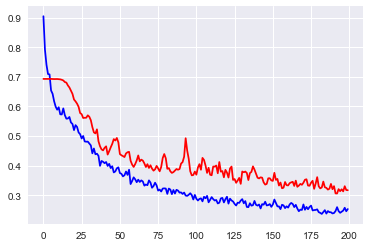

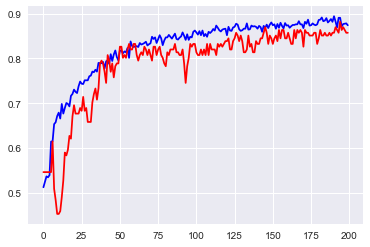

In [25]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [26]:
saveModel(model, run_name_acc)

## 3. Predict

In [27]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

D:\ref\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_3channel_Inception_20180105_181724_3241.csv


In [28]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.1705227 ]
 [ 0.35115305]]
(8424, 1)
[[ 0.1705227 ]
 [ 0.35115305]]


In [29]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.170523
1  4023181e    0.351153
(8424, 2)


In [30]:
t1 = time.time()
print('time cost: %.2f s' % (t1-t0))
print(run_name_acc)
print('Done!')

time cost: 312.59 s
SC_Iceberg_Classifier_CNN_3channel_Inception_20180105_181724_3241
Done!
